In [1]:
# needed imports
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import ward, fcluster, cut_tree
from scipy.spatial.distance import pdist
from sklearn.metrics import matthews_corrcoef
import phik
from openpyxl import load_workbook

In [19]:
#Import Data, droping Summe and ID

X_original = pd.read_excel("./reduced_table_with_timestamps_and_props.xlsx", "X_clustering")
X = X_original.drop(columns=['ID'], index = 0)
software = list(X.columns)

X_transpose = X.transpose()
#created = list(X_transpose[0])
X_transpose = X.transpose()

X_original.set_index('ID', inplace = True)


In [29]:
def hierarchical_clustering(software_labels, input_data):

    #Berechne Distanzmatric mit dem phi-coeffizienten
    labels = software_labels

    #Methode ward
    Y_phi = input_data.phik_matrix(interval_cols = software)
    Z_phi = ward(Y_phi)

    p = len(labels)
    R = sch.dendrogram(
        Z_phi,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=p,  # show only the last p merged clusters
        no_plot=True,
        )
    temp = {R["leaves"][ii]: labels[ii] for ii in range(len(R["leaves"]))}
    def llf(xx):
        return "{}".format(temp[xx])



    #Zeichne das zugehöhrige dendrogram
    plt.figure(figsize=(120, 15))
    sch.dendrogram(
        Z_phi,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=p,  # show only the last p merged clusters
        leaf_label_func=llf,
        leaf_rotation=60.,
        leaf_font_size=12.,
        show_contracted=True,  # to get a distribution impression in truncated branches
        )

    plt.show()
    
    return Z_phi

#Software, die keine Techniken nutzen werden gefiltert

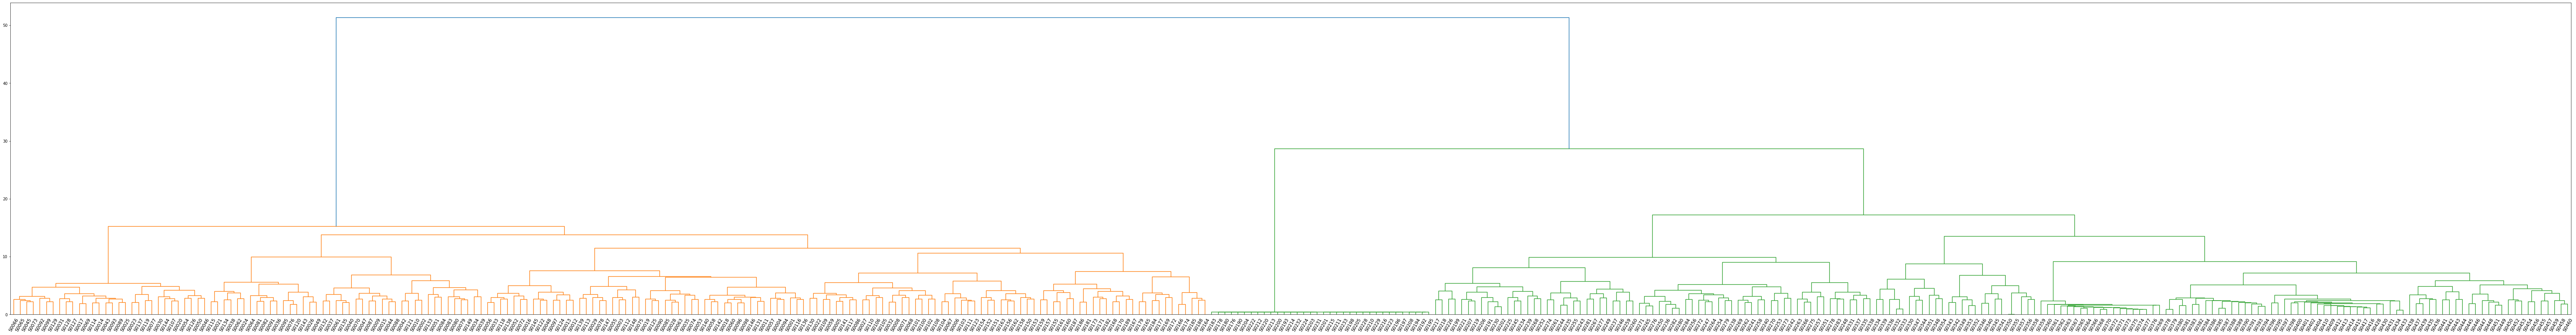

In [30]:
Z_phi = hierarchical_clustering(software, X)

In [31]:
Z_phi

array([[2.60000000e+01, 5.90000000e+01, 4.96782191e-02, 2.00000000e+00],
       [4.10000000e+01, 4.30000000e+01, 4.21605473e-01, 2.00000000e+00],
       [4.50000000e+01, 3.90000000e+02, 4.21605473e-01, 3.00000000e+00],
       ...,
       [7.67000000e+02, 7.71000000e+02, 1.71916237e+01, 1.73000000e+02],
       [4.22000000e+02, 7.74000000e+02, 2.86716408e+01, 2.07000000e+02],
       [7.73000000e+02, 7.75000000e+02, 5.13522658e+01, 3.89000000e+02]])

In [34]:
#Running Program to save hierarchcal clustering in Excel
cluster_id, cluster_level = cut_tree_balanced(Z_phi, 20)

X_original.loc['Cluster-ID'] = cluster_id

X_original.to_csv('clustering_x.csv', sep = ";")



#with pd.ExcelWriter('./Data with time stemps reduced.xlsx', engine="openpyxl", mode = 'a') as writer:
 #   X_original.to_excel(writer, sheet_name = 'Datamatrix with time and cluster')

In [6]:
# Quelle: https://github.com/vreyespue/scipy_cut_tree_balanced/blob/master/scipy_cut_tree_balanced/util.py
# Methode um den Tree balanciert zu cutten
def cut_tree_balanced(Z, max_cluster_size):
    """
    Parameters
    ----------
    Z : ndarray
        The linkage matrix resulting from calling `ward` or `linkage`. I.e. it
        contains the hierarchical clustering encoded as a linkage matrix.
    max_cluster_size : int
        Maximum number of data samples contained within the resulting clusters.
        Thus, all resulting clusters will contain a number of data samples
        ``<= max_cluster_size``. Must be >= 1.
    Returns
    -------
    cluster_id : ndarray
        One-dimensional array of integers containing for each input sample its
        corresponding cluster id. The cluster id is an integer which is higher
        for deeper tree levels.
    cluster_level : ndarray
        One-dimensional array of integer arrays containing for each input
        sample its corresponding cluster tree level, i.e. a sequence of
        0's and 1's. Note that the cluster level is longer for deeper tree
        levels, being [0] the root cluster, [0, 0] and [0, 1] its offspring,
        and so on. Also note that in each cluster splitting, the label 0
        denotes the bigger cluster, while the label 1 denotes the smallest.
    See Also
    --------
    cut_tree
    Notes
    -----
"""
    # Assert that the input max_cluster_size is >= 1
    if not max_cluster_size >= 1:
        raise ValueError(
            "max_cluster_size should be >= 1, is: {}".format(max_cluster_size)
        )

    # Perform a full cut tree of the linkage matrix
    full_cut = cut_tree(Z_phi)

    # Initialize the variable containing the current cluster id (it will be
    # higher for each newly found valid cluster)
    last_cluster_id = 0

    # Initialize the resulting cluster id vector (containing for each row in
    # input_data_x_sample its corresponding cluster id)
    ndim = full_cut.shape[1]
    cluster_id = np.zeros(ndim, dtype=int)

    # Initialize the resulting cluster level vector (containing for each data
    # sample its corresponding cluster tree level)
    cluster_level = np.empty((ndim,), dtype=object)
    for i in range(ndim):
        cluster_level[i] = np.array([0], int)

    # Scan the full cut matrix from the last column (root tree level) to the
    # first column (leaves tree level)
    for icol in range(ndim - 1, -1, -1):
        # Get a list of unique group ids and their count within the current
        # tree level
        values, counts = np.unique(full_cut[:, icol], return_counts=True)

        # Stop if all samples have been already selected (i.e. if all data
        # samples have been already clustered)
        if (values.size == 1) and (values[0] == -1):
            break

        # For each group id within the current tree level
        for ival in range(values.size):
            # If it is a valid group id (i.e. not yet marked with -1)
            # Note: data samples which were alredy included in a valid
            # cluster id are marked with the group id -1 (see below)
            if values[ival] >= 0:
                # Select the current group id
                selected_curr_value = values[ival]

                # Look for the vector positions (related to rows in
                # input_data_x_sample) belonging to the current group id
                selected_curr_elems = np.where(full_cut[:, icol] == selected_curr_value)

                # Major step #1: Populate the resulting vector of cluster
                # levels for each data sample, if we are not at the root
                if icol < (ndim - 1):
                    # Get the ancestor values and element positions
                    selected_ancestor_value = full_cut[
                        selected_curr_elems[0][0], icol + 1
                    ]
                    selected_ancestor_elems = np.where(
                        full_cut[:, icol + 1] == selected_ancestor_value
                    )

                    # Compute the values and counts of the offspring and sort
                    # them by their count (so that the biggest cluster gets the
                    # offspring_elem_label = 0, see below)
                    offspring_values, offspring_counts = np.unique(
                        full_cut[selected_ancestor_elems, icol], return_counts=True
                    )
                    count_sort_ind = np.argsort(-offspring_counts)
                    offspring_values = offspring_values[count_sort_ind]
                    offspring_counts = offspring_counts[count_sort_ind]

                    # If the size of the offspring is > 1
                    if offspring_values.shape[0] > 1:
                        # Select the label of the current value (i.e. 0 or 1)
                        # and append it to the cluster level
                        offspring_elem_label = np.where(
                            offspring_values == selected_curr_value
                        )[0][0]
                        for i in selected_curr_elems[0]:
                            cluster_level[i] = np.hstack(
                                (cluster_level[i], offspring_elem_label)
                            )

                # Major step #2: Populate the resulting vector of cluster ids
                # for each data sample, and mark them as clustered (-1)
                # If the number of elements is below max_cluster_size
                if counts[ival] <= max_cluster_size:
                    # Relate vector positions to the current cluster id
                    cluster_id[selected_curr_elems] = last_cluster_id

                    # Delete these vector positions at lower tree levels for
                    # further processing (i.e. mark as clustered)
                    full_cut[selected_curr_elems, 0:icol] = -1

                    # Update the cluster id
                    last_cluster_id += 1

    # Return the resulting clustering array (containing for each row in
    # input_data_x_sample its corresponding cluster id)
    return cluster_id, cluster_level